# Обучение моделей

# <a id="0">Содержание</a>

- <a href="#1">Импорт необходимых библиотек</a>
- <a href="#2">Проверка гипотезы об эмбединге признаков</a> 
    - <a href="#21">Проверка гипотезы для регрессии</a>
    - <a href="#22">Проверка гипотезы для классификации</a>
- <a href="#3">Подбор параметров и обучение различных моделей регрессии</a>  
    - <a href="#31">LightGBM</a>
    - <a href="#32">CatBoost</a>
    - <a href="#33">XGBoost</a>
    - <a href="#34">Сравнение 3-х моделей регрессии</a>
- <a href="#4">Подбор параметров и обучение различных моделей классификации</a>  
    - <a href="#41">CatBoost</a>
    - <a href="#42">LightGBM</a>
    - <a href="#43">XGBoost</a>
    - <a href="#44">Сравнение 3-х моделей классификации</a>
- <a href="#5">Получим предсказания для данных на 2024 год</a>  

## <a id="1">Импорт необходимых библиотек</a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, r2_score

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

import pickle
import time

import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

import matplotlib.pyplot as plt
import seaborn as sns

## <a id="2">Проверка гипотезы об эмбединге признаков</a>

### <a id="21">Проверка гипотезы для регрессии</a>

Попробуем обучить 2 модели на данных с эмбедингами признаков и без, возьмем LightGBM, поскольку на ее обучение уходит меньше времени.

In [28]:
# Загрузим данные embedding
df_emb = pd.read_csv('../feature_selection/data/embedding_features.csv')

# Загрузим данные без embedding
df = pd.read_csv('../feature_selection/data/raw_selected_data.csv')

In [102]:
# Выделим таргет на данных с эмбедингом
X_emb = df_emb.drop(['percent_nClick', 'BinNclick'], axis=1)
y_emb = df_emb['percent_nClick']

# Выделим таргет на данных без эмбединга
X_reg = df.drop(['percent_nClick', 'BinNclick'], axis=1)
y_reg = df['percent_nClick']

# Разобьем обе выборки на обучающие и тестовые
X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(
    X_emb, y_emb, test_size=0.2, random_state=42
)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Стандартизируем данные
sc=StandardScaler()

sc.fit(X_train_em)
X_train_em=sc.transform(X_train_em)
X_test_em=sc.transform(X_test_em)

sc.fit(X_train_reg)
X_train_reg=sc.transform(X_train_reg)
X_test_reg=sc.transform(X_test_reg)

In [103]:
# Обучим модель регрессии на данных с эмбедингом
lgbm_reg = LGBMRegressor(verbose=-1)
lgbm_reg.fit(X_train_em, y_train_em)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_em)

# Считаем основные метрики
mse_lgbm_emb = mean_squared_error(y_test_em, y_pred_lgbm_reg)
r2_lgbm_emb = r2_score(y_test_em, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"MSE LightGBM with Embedding: {round(mse_lgbm_emb, 3)}")
print(f"R2_score LightGBM with Embedding: {round(r2_lgbm_emb, 3)*100}%")

MSE LightGBM with Embedding: 0.01
R2_score LightGBM with Embedding: 76.2%


In [105]:
# Обучим модель регрессии на данных без эмбединга
lgbm_reg = LGBMRegressor(verbose=-1)
lgbm_reg.fit(X_train_reg, y_train_reg)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_reg)

# Считаем основные метрики
mse_lgbm_reg = mean_squared_error(y_test_reg, y_pred_lgbm_reg)
r2_lgbm_reg = r2_score(y_test_reg, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"MSE LightGBM without Embedding: {round(mse_lgbm_reg, 3)}")
print(f"R2_score LightGBM without Embedding: {round(r2_lgbm_reg, 3)*100}%")

MSE LightGBM without Embedding: 0.007
R2_score LightGBM without Embedding: 83.5%


Как видно из метрик качества данные без эмбединга показывают себя лучше, в дальнейшем эти показатели можно будет улучшить за счет подбора параметров

### <a id="22">Проверка гипотезы для классификации</a>

Аналогично обучим 2 модели, одну на данных с эмбедингом другую без и посмотрим на метрики качества.

In [106]:
# Выделим таргет на данных с эмбедингом
X_emb = df_emb.drop(['percent_nClick', 'BinNclick'], axis=1)
y_emb = df_emb['BinNclick']

# Выделим таргет на данных без эмбединга
X_reg = df.drop(['percent_nClick', 'BinNclick'], axis=1)
y_reg = df['BinNclick']

# Разобьем обе выборки на обучающие и тестовые
X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(
    X_emb, y_emb, test_size=0.2, random_state=42
)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Стандартизируем данные
sc=StandardScaler()

sc.fit(X_train_em)
X_train_em=sc.transform(X_train_em)
X_test_em=sc.transform(X_test_em)

sc.fit(X_train_reg)
X_train_reg=sc.transform(X_train_reg)
X_test_reg=sc.transform(X_test_reg)

In [107]:
# Обучим модель
lgbm_class = LGBMClassifier(verbose=-1)
lgbm_class.fit(X_train_em, y_train_em)

# Предсказание
y_pred_lgbm_class = lgbm_class.predict(X_test_em)
f1_lgbm_emb = f1_score(y_test_em, y_pred_lgbm_class)

# Выводим основные метрики
print(f"F1-score LightGBM with Embedding: {round(f1_lgbm_emb, 3)}")

F1-score LightGBM with Embedding: 0.78


In [108]:
# Обучим модель
lgbm_class = LGBMClassifier(verbose=-1)
lgbm_class.fit(X_train_reg, y_train_reg)

# Предсказание
y_pred_lgbm_class = lgbm_class.predict(X_test_reg)
f1_lgbm_reg = f1_score(y_test_reg, y_pred_lgbm_class)

# Выводим основные метрики
print(f"F1-score LightGBM without Embedding: {round(f1_lgbm_reg, 3)}")

F1-score LightGBM without Embedding: 0.853


> Аналогично результату в моделях регрессии, модель классификации на данных без эмбединга показала себя лучше, так что можно сделать вывод, что гипотеза с простым энкодером не подтверждается.

> Для дальнейшего обучения моделей будем использовать данные из raw_selected_data.csv

## <a id="3">Подбор параметров и обучение различных моделей регрессии</a>

Обучим 3 модели регрессии LightGBMRegressor, CatBoostRegressor, XGBRegressor

In [2]:
# Загрузим данные
df = pd.read_csv('../feature_selection/data/raw_selected_data.csv')
df.head()

,Unnamed: 0,Amount,nCount,Weight,Volume,OKVED_395.0,OKVED_0.0,BeginMonth_1,OKVED_296.0,BeginMonth_2,...,OKVED_317.0,OKVED_373.0,ActivityArea_64.0,ActivityArea_95.0,ActivityArea_42.0,ActivityArea_72.0,OKVED_11.0,ActivityArea_121.0,BinNclick,percent_nClick
0,0,-0.148895,-0.181508,-0.292518,-0.279925,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,1,-0.148895,-0.181508,-0.292518,-0.077765,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
2,2,-0.148895,-0.156237,-0.292518,-0.178845,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
3,3,-0.148895,-0.181508,-0.292518,-0.279925,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,4,-0.148895,-0.181508,-0.292518,-0.077765,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0


In [3]:
# Выделим таргет
X = df.drop(['percent_nClick', 'BinNclick'], axis=1)
y = df['percent_nClick']

# Разобьем выборки на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизируем данные
sc = StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

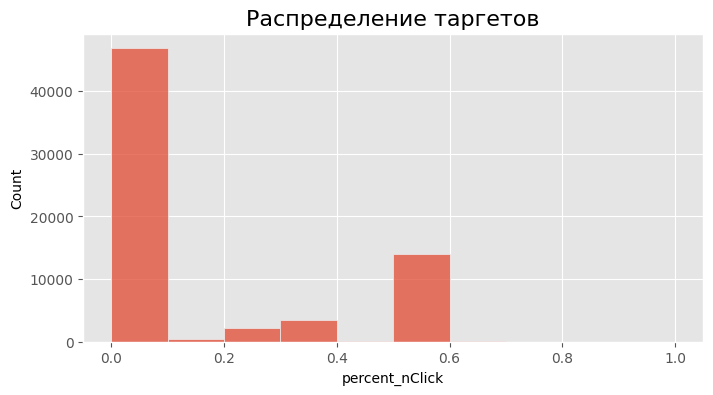

In [120]:
fig = plt.figure(figsize=(8, 4))
histplot = sns.histplot(
    data=df,
    x='percent_nClick',
    bins=10,
    #kde=True,
)
histplot.set_title('Распределение таргетов', fontsize=16)

### <a id="31">LightGBM</a>

In [57]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbosity':-1,
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train, y_train)
    
    # Предсказание
    y_pred = optuna_model.predict(X_test)
    
    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=100)

[I 2024-05-22 09:59:02,422] A new study created in memory with name: no-name-fb81429e-3037-4dfe-b80c-69fccce55872
[I 2024-05-22 09:59:04,505] Trial 0 finished with value: 0.005894907044457385 and parameters: {'lambda_l2': 0.581438225691, 'max_depth': 39, 'num_leaves': 15, 'learning_rate': 0.741, 'bagging_fraction': 0.5}. Best is trial 0 with value: 0.005894907044457385.
[I 2024-05-22 09:59:06,487] Trial 1 finished with value: 0.009979817064784601 and parameters: {'lambda_l2': 0.8270731670759789, 'max_depth': 15, 'num_leaves': 15, 'learning_rate': 0.041, 'bagging_fraction': 0.8}. Best is trial 0 with value: 0.005894907044457385.
[I 2024-05-22 09:59:09,068] Trial 2 finished with value: 0.004538827643908893 and parameters: {'lambda_l2': 0.9110952897030674, 'max_depth': 93, 'num_leaves': 95, 'learning_rate': 0.521, 'bagging_fraction': 0.8}. Best is trial 2 with value: 0.004538827643908893.
[I 2024-05-22 09:59:10,999] Trial 3 finished with value: 0.004769362320938971 and parameters: {'lambd

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\1341559625.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm_reg)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

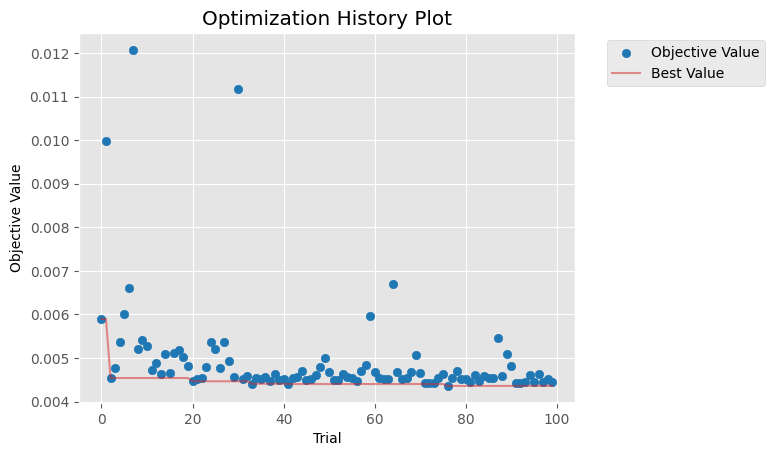

In [58]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_lgbm_reg)

In [142]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MSE: 0.004357638806619373
  Параметры: 
    lambda_l2: 0.5507629596435024
    max_depth: 60
    num_leaves: 105
    learning_rate: 0.331
    bagging_fraction: 0.7


In [137]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test)

# Конец временного промежутка
lgbm_reg_time = time.time() - start_time

# Считаем основные метрики
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"MSE LightGBM: {mse_lgbm:.3f}")
print(f"R2_score LightGBM: {r2_lgbm * 100 :.2f}%")
print(f"Время обучения LightGBM: {lgbm_reg_time:.2f} сек")

MSE LightGBM: 0.004
R2_score LightGBM: 89.71%
Время обучения LightGBM: 2.57 сек


In [61]:
# Сохраним модель
with open(r'models/lgb_reg_model.pkl', 'wb') as file:
    pickle.dump(lgbm_reg, file)

### <a id="32">CatBoost</a>

In [62]:
def objective_catb_reg(trial):
    # Подбираемые параметры
    params={
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': 0,
    }

    # Обучаем модель
    optuna_model = CatBoostRegressor(**params)
    optuna_model.fit(X_train, y_train)
    
    # Предсказание
    y_pred = optuna_model.predict(X_test)
    
    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_catb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_catb_reg.optimize(objective_catb_reg, n_trials=100)

[I 2024-05-22 10:03:38,582] A new study created in memory with name: no-name-b021e396-80c1-4aae-842d-3f0f8cddb8eb
[I 2024-05-22 10:04:03,196] Trial 0 finished with value: 0.010515492619275677 and parameters: {'iterations': 857, 'learning_rate': 0.0048076762013427345, 'depth': 8, 'l2_leaf_reg': 0.015216063002927013, 'random_strength': 7.889832478879645e-07, 'bagging_temperature': 2.48238463716281, 'od_type': 'Iter', 'od_wait': 27}. Best is trial 0 with value: 0.010515492619275677.
[I 2024-05-22 10:04:10,807] Trial 1 finished with value: 0.01032764121369676 and parameters: {'iterations': 210, 'learning_rate': 0.018068715741037862, 'depth': 9, 'l2_leaf_reg': 0.18744188388579863, 'random_strength': 0.0059527136984933145, 'bagging_temperature': 1.7620777294107093, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 1 with value: 0.01032764121369676.
[I 2024-05-22 10:04:27,839] Trial 2 finished with value: 0.008192877841740737 and parameters: {'iterations': 694, 'learning_rate': 0.018758808

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\1089751886.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_catb_reg)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

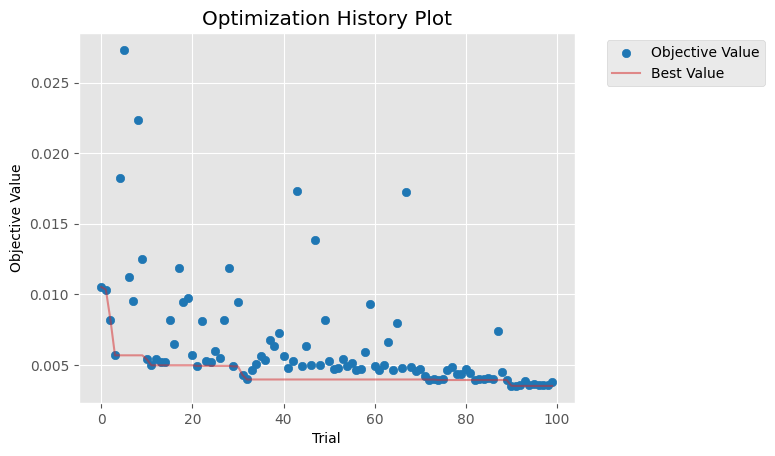

In [63]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_catb_reg)

In [139]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_catb_reg.trials)))
print('Лучший трайл:')
trial = study_catb_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MSE: 0.0035100561332635878
  Параметры: 
    iterations: 971
    learning_rate: 0.09772174146089817
    depth: 10
    l2_leaf_reg: 6.607542138866637e-08
    random_strength: 5.4467745740852526e-06
    bagging_temperature: 4.350498445028115
    od_type: Iter
    od_wait: 12


In [140]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
catb_reg = CatBoostRegressor(verbose=0,**params)
catb_reg.fit(X_train, y_train)

# Предсказание
y_pred_catb_reg = catb_reg.predict(X_test)

# Конец временного промежутка
catb_reg_time = time.time() - start_time

# Считаем основные метрики
mse_catb = mean_squared_error(y_test, y_pred_catb_reg)
r2_catb = r2_score(y_test, y_pred_catb_reg)

# Выводим основные метрики
print(f"MSE CatBoost: {mse_catb:.3f}")
print(f"R2_score CatBoost: {r2_catb * 100 :.2f}%")
print(f"Время обучения CatBoost: {catb_reg_time:.2f} сек")

MSE CatBoost: 0.004
R2_score CatBoost: 91.71%
Время обучения CatBoost: 62.07 сек


In [66]:
# Сохраним модель
with open(r'models/catb_reg_model.pkl', 'wb') as file:
    pickle.dump(catb_reg, file)

### <a id="33">XGBoost</a>

In [67]:
def objective_xgb_reg(trial):
    # Подбираемые параметры
    params={
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучаем модель
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(X_train, y_train)
    
    # Предсказание
    y_pred = optuna_model.predict(X_test)
    
    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_xgb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_xgb_reg.optimize(objective_xgb_reg, n_trials=50)

[I 2024-05-22 11:01:25,489] A new study created in memory with name: no-name-ecf92058-5fe4-4c71-9b7d-f26a81080aba
[I 2024-05-22 11:01:51,687] Trial 0 finished with value: 0.01160131337828343 and parameters: {'learning_rate': 0.013119656515868305, 'n_estimators': 242, 'max_depth': 4, 'subsample': 0.834610823418394, 'colsample_bytree': 0.6902890846544714}. Best is trial 0 with value: 0.01160131337828343.
[I 2024-05-22 11:03:56,956] Trial 1 finished with value: 0.001450949674192227 and parameters: {'learning_rate': 0.15764313995540374, 'n_estimators': 871, 'max_depth': 6, 'subsample': 0.7191249757319864, 'colsample_bytree': 0.8206489252789364}. Best is trial 1 with value: 0.001450949674192227.
[I 2024-05-22 11:04:29,760] Trial 2 finished with value: 0.005070399270222945 and parameters: {'learning_rate': 0.1486393579422033, 'n_estimators': 328, 'max_depth': 4, 'subsample': 0.5234542777549596, 'colsample_bytree': 0.7495823760326832}. Best is trial 1 with value: 0.001450949674192227.
[I 2024

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\984470995.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_xgb_reg)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

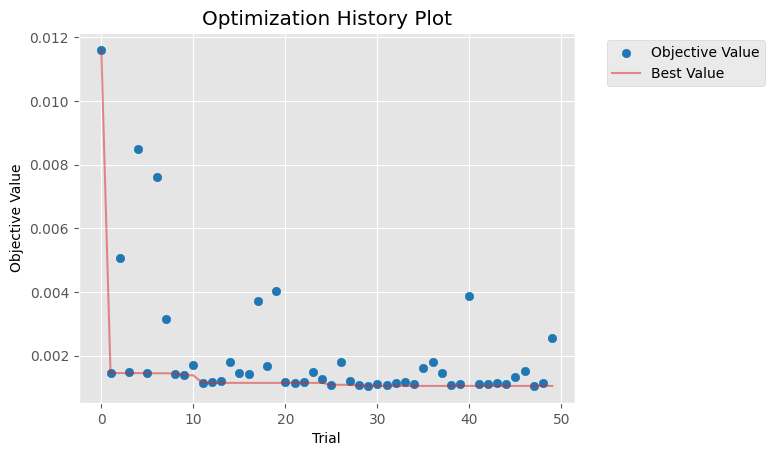

In [68]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_xgb_reg)

In [128]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_xgb_reg.trials)))
print('Лучший трайл:')
trial = study_xgb_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 50
Лучший трайл:
  Лучший MSE: 0.0010474647262889054
  Параметры: 
    learning_rate: 0.15205271626287672
    n_estimators: 987
    max_depth: 9
    subsample: 0.8610573961037491
    colsample_bytree: 0.6994393300474311


In [81]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
xgb_reg = XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)

# Предсказание
y_pred_xgb_reg = xgb_reg.predict(X_test)

# Конец временного промежутка
xgb_reg_time = time.time() - start_time

# Считаем основные метрики
mse_xgb = mean_squared_error(y_test, y_pred_xgb_reg)
r2_xgb = r2_score(y_test, y_pred_xgb_reg)

# Выводим основные метрики
print(f"MSE XGBoost: {mse_xgb:.3f}")
print(f"R2_score XGBoost: {r2_xgb * 100 :.2f}%")
print(f"Время обучения LightGBM: {xgb_reg_time:.2f} сек")

MSE XGBoost: 0.001
R2_score XGBoost: 97.5%
Время обучения LightGBM: 257.07 сек


In [71]:
# Сохраним модель
with open(r'models/xgb_reg_model.pkl', 'wb') as file:
    pickle.dump(xgb_reg, file)

### <a id="34">Сравнение 3-х моделей регрессии</a>

In [141]:
# Соберем основные метрики по моделям в одну таблицу
regression_df = pd.DataFrame(
    data = [
        [f'{mse_lgbm:.4f}', f'{mse_catb:.4f}', f'{mse_xgb:.4f}'],
        [f'{r2_lgbm*100:.1f}%', f'{r2_catb*100:.1f}%', f'{r2_xgb*100:.1f}%'],
        [f'{lgbm_reg_time:.2f} сек', f'{catb_reg_time:.2f} сек', f'{xgb_reg_time:.2f} сек']
    ],
    columns= ['LightGBM', 'CatBoost', 'XGBoost'],
    index = ['MSE', 'R2-score', 'Time']
)
display(regression_df)

,LightGBM,CatBoost,XGBoost
MSE,0.0044,0.0035,0.0010
R2-score,89.7%,91.7%,97.5%
Time,2.57 сек,62.07 сек,257.07 сек


> Как видно из таблицы лучший результат из данных моделей показывает XGBoost, но также у этой модели уходит в разы больше времени на обучение, чем у остальных. В целом можно сделать вывод, что все 3 модели отлично справляются с предсказанием вероятности того, что клиент откроет ссылку в письме, о чем нам говорит метрика r2 > 80%.

## <a id="4">Подбор параметров и обучение различных моделей классификации</a>

Обучим 3 модели классификации CatBoostClassifier, LightGBMClassifier,  XGBClassifier

In [4]:
# Выделяем таргет
X = df.drop(['percent_nClick', 'BinNclick'], axis=1)
y = df['BinNclick']

# Разделяем данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизируем данные
sc = StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

# Посмотрим распределение меток по данным
print(f'Распределение в обучающих данных: {y_train.value_counts()}')
print(f'Распределение в тестовых данных: {y_test.value_counts()}')

Распределение в обучающих данных: BinNclick
0    42056
1    11431
Name: count, dtype: int64
Распределение в тестовых данных: BinNclick
0    10648
1     2724
Name: count, dtype: int64


> Как видно из показателей выше, в наших данных наблюдается дисбаланс, модель CatBoost невосприимчива к дисбалансу, так что для нее необязательно проводить балансировку классов, для моделей LightGBM и XGBoost это сделать необходимо.

### <a id="41">CatBoost</a>

In [165]:
def objective_catb_class(trial):
    """Определение целевой функции для CatBoost Classification"""

    # Подбираемые параметры
    params = {
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': 0,
    }

    # Обучение модели
    optuna_model = CatBoostClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка полученного предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_catb_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_catb_class.optimize(objective_catb_class, n_trials=50)

[I 2024-05-22 15:23:53,027] A new study created in memory with name: no-name-188e0497-b88f-4be7-ab2c-8adb63834264
[I 2024-05-22 15:24:31,039] Trial 0 finished with value: 0.8080771979985705 and parameters: {'iterations': 549, 'learning_rate': 0.005156522292570936, 'depth': 9, 'l2_leaf_reg': 2.1641068257985447e-08, 'random_strength': 0.0008708942447073417, 'bagging_temperature': 5.5490809700417305, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 0 with value: 0.8080771979985705.
[I 2024-05-22 15:25:07,599] Trial 1 finished with value: 0.8688078388677191 and parameters: {'iterations': 330, 'learning_rate': 0.04299716397855776, 'depth': 10, 'l2_leaf_reg': 0.0032194309559669143, 'random_strength': 1.566755139869745, 'bagging_temperature': 2.746148117738225, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 1 with value: 0.8688078388677191.
[I 2024-05-22 15:25:21,391] Trial 2 finished with value: 0.7677895874617187 and parameters: {'iterations': 378, 'learning_rate': 0.0108154362960

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\1410142372.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_catb_class)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

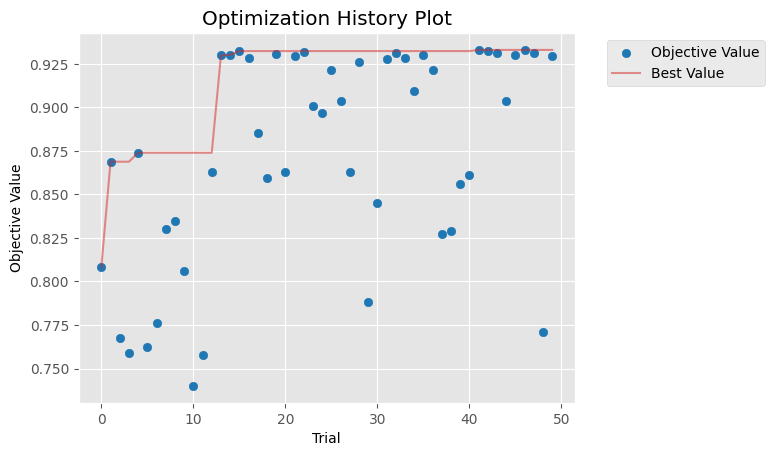

In [166]:
# Посмотрим как проходил процесс подбора параметров на графике
plot_optimization_history(study_catb_class)

In [184]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_catb_class.trials)))
print('Лучший трайл:')
trial = study_catb_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 50
Лучший трайл:
  Лучший F1-score: 0.9330116904806086
  Параметры: 
    iterations: 997
    learning_rate: 0.09941272508155655
    depth: 9
    l2_leaf_reg: 0.00016473468611727648
    random_strength: 0.05546302057376024
    bagging_temperature: 6.617984001195061
    od_type: IncToDec
    od_wait: 16


In [185]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель с полученными параметрами
params = trial.params
catb_class = CatBoostClassifier(verbose=0,**params)
catb_class.fit(X_train, y_train)

# Конец временного промежутка
catb_class_time = time.time() - start_time

# Предсказание
y_pred_catb_class = catb_class.predict(X_test)

# Считаем основные метрики
f1_catb = f1_score(y_test, y_pred_catb_class)
acc_catb = accuracy_score(y_test, y_pred_catb_class)
prec_catb = precision_score(y_test, y_pred_catb_class)
rec_catb = recall_score(y_test, y_pred_catb_class)

# Посмотрим на основные метрики качества
print(f"F1-score CatBoost: {f1_catb:.3f}")
print(f"Time CatBoost: {catb_class_time:.3f} сек")
print('Classification report CatBoost:')
print(classification_report(y_test, y_pred_catb_class))

F1-score CatBoost: 0.933
Time CatBoost: 61.085 сек
Classification report CatBoost:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10648
           1       0.94      0.92      0.93      2724

    accuracy                           0.97     13372
   macro avg       0.96      0.95      0.96     13372
weighted avg       0.97      0.97      0.97     13372



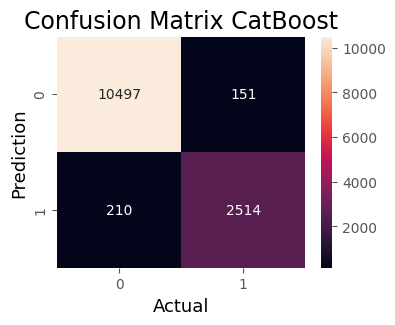

In [169]:
# Потроим матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_catb = confusion_matrix(y_test, y_pred_catb_class)
sns.heatmap(con_mat_catb,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix CatBoost', fontsize=17)
plt.show()

Согласно метрикам качества данная модель показала хороший результат. Согласно матрице, ошибок первого рода чуть больше, чем ошибок второго рода, т.е. больше вероятность того, что будет отправлено письмо, которое не будет прочитано, чем того что мы не отправим письмо человеку, который бы его прочитал.

$P_1>P_2$, где 

$P_1$ - отправлено письмо, которое не будет прочитано;

$P_2$ - письмо отправлено человеку, который бы его прочитал.

In [170]:
# Сохраним полученную модель
with open(r'models/catb_class_model.pkl', 'wb') as file:
    pickle.dump(catb_class, file)

In [5]:
# Загрузка модели из файла
with open(r'models/catb_class_model.pkl', 'rb') as file:
    catb_class = pickle.load(file)

In [8]:
# Пример кода для построения графика precision, recall и доли прогнозных "плохих" клиентов
def plot_metrics_at_thresholds(y_true, y_pred_proba):
    """
    Функция для построения графиков precision, recall и доли прогнозных "плохих" клиентов 
    при различных порогах вероятностей.
    
    Параметры:
    y_true (array-like): Истинные значения меток классов.
    y_pred_proba (array-like): Предсказанные вероятности принадлежности к классу 1.
    """

    # Определяем пороги от 0.0 до 1.0 с шагом 0.05
    thresholds = np.arange(0.0, 1.05, 0.05)
    # Инициализируем списки для хранения значений precision, recall и доли "плохих" клиентов для каждого порога
    precisions = []
    recalls = []
    bad_client_ratios = []
    # Перебираем каждый порог
    for threshold in thresholds:
        # Присваиваем класс 1, если вероятность больше или равна текущему порогу, иначе 0
        y_pred = (y_pred_proba >= threshold).astype(int)
        # Вычисляем precision для текущего порога
        precision = precision_score(y_true, y_pred)
        # Вычисляем recall для текущего порога
        recall = recall_score(y_true, y_pred)
        # Вычисляем долю прогнозных "плохих" клиентов (классов 1) для текущего порога
        bad_client_ratio = np.mean(y_pred)
        # Добавляем вычисленные значения в соответствующие списки
        precisions.append(precision)
        recalls.append(recall)
        bad_client_ratios.append(bad_client_ratio)

    # Строим график зависимости precision от порога
    plt.plot(thresholds, precisions, label='precision')
    # Строим график зависимости recall от порога
    plt.plot(thresholds, recalls, label='recall')
    # Строим график зависимости доли прогнозных "плохих" клиентов от порога
    plt.plot(thresholds, bad_client_ratios, label='Доля прогнозных плохих клиентов')
    # Добавляем подпись для оси X
    plt.xlabel('Порог')
    # Добавляем подпись для оси Y
    plt.ylabel('Доля')
    # Добавляем заголовок графика
    plt.title('Метрики при различных порогах')
    # Отображаем легенду
    plt.legend()
    # Отображаем сетку на графике
    plt.grid()
    # Показываем график
    plt.show()

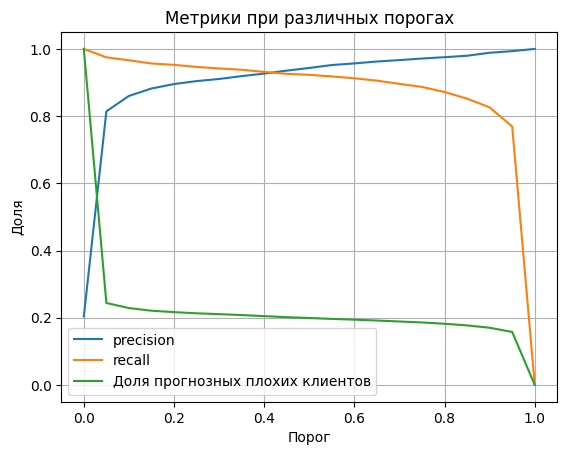

In [9]:
# Используйте ваши предсказания и истинные значения
y_true = y_test
y_pred_proba = catb_class.predict_proba(X_test)[:, 1]

# Построим график
plot_metrics_at_thresholds(y_true, y_pred_proba)

По графику можно сказать что:
- Precision (Точность):
    - Precision на высоких значениях порога (ближе к 1) почти достигает 1, что указывает на то, что при высоком пороге все предсказанные "плохие" клиенты действительно являются таковыми.
    - При уменьшении порога precision немного падает, но остается на высоком уровне до порога около 0.1-0.2, после чего начинает стремительно снижаться. Это означает, что при низких порогах модель начинает допускать больше ложных срабатываний, т.е. классифицирует больше клиентов как "плохих", хотя они таковыми не являются.

- Recall (Полнота):
    - Recall наоборот, растет с уменьшением порога и достигает максимума при низких порогах. Это означает, что модель обнаруживает большинство "плохих" клиентов при низких порогах.
    - Высокий recall при низких порогах указывает на то, что модель практически не пропускает "плохих" клиентов, но это происходит за счет большого числа ложных срабатываний, что видно по падению precision.

- Доля прогнозных "плохих" клиентов:
    - Доля прогнозных "плохих" клиентов стремительно падает с уменьшением порога, особенно на промежутке 0.0-0.1. Это указывает на то, что при низких порогах модель классифицирует значительное число клиентов как "плохих", хотя это далеко не всегда так.
    - С увеличением порога доля стабилизируется и медленно снижается, что может указывать на устойчивость модели в определении "плохих" клиентов при низких порогах до 0,9. 

In [14]:
def plot_cumulative_buckets(y_true, y_pred_proba):
    """
    Функция для построения графиков доли прогнозных "плохих" клиентов 
    и доли прогнозных "плохих" среди фактических клиентов по кумулятивным бакетам.
    
    Параметры:
    y_true (array-like): Истинные значения меток классов.
    y_pred_proba (array-like): Предсказанные вероятности принадлежности к классу 1.
    """
    
    # Преобразуем pandas Series в numpy массивы, если это необходимо
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred_proba, pd.Series):
        y_pred_proba = y_pred_proba.values
    # Сортируем индексы предсказанных вероятностей в порядке возрастания
    sorted_indices = np.argsort(y_pred_proba)
    # Используем отсортированные индексы для сортировки истинных значений и предсказанных вероятностей
    sorted_y_true = y_true[sorted_indices]
    sorted_y_pred_proba = y_pred_proba[sorted_indices]
    # Формируем кумулятивные бакеты (накопленные доли от 0 до 1)
    cumulative_buckets = np.arange(1, len(y_true) + 1) / len(y_true)
    # Вычисляем долю прогнозных "плохих" клиентов среди фактических на каждом этапе
    bad_client_ratios = np.cumsum(sorted_y_true) / np.arange(1, len(y_true) + 1)
    # Вычисляем долю прогнозных "плохих" клиентов на каждом этапе
    predicted_bad_client_ratios = np.cumsum((sorted_y_pred_proba >= 0.5).astype(int)) / np.arange(1, len(y_true) + 1)
    # Строим график зависимости доли прогнозных "плохих" клиентов среди фактических
    plt.plot(cumulative_buckets, bad_client_ratios, label='Доля прогнозных плохих среди фактических')
    # Строим график зависимости доли прогнозных "плохих" клиентов
    plt.plot(cumulative_buckets, predicted_bad_client_ratios, label='Доля прогнозных плохих клиентов')
    # Добавляем подпись для оси X
    plt.xlabel('Кумулятивный бакет')
    # Добавляем подпись для оси Y
    plt.ylabel('Доля')
    # Добавляем заголовок графика
    plt.title('Доля прогнозных плохих клиентов при различных порогах')
    # Отображаем легенду
    plt.legend()
    # Отображаем сетку на графике
    plt.grid()
    # Показываем график
    plt.show()

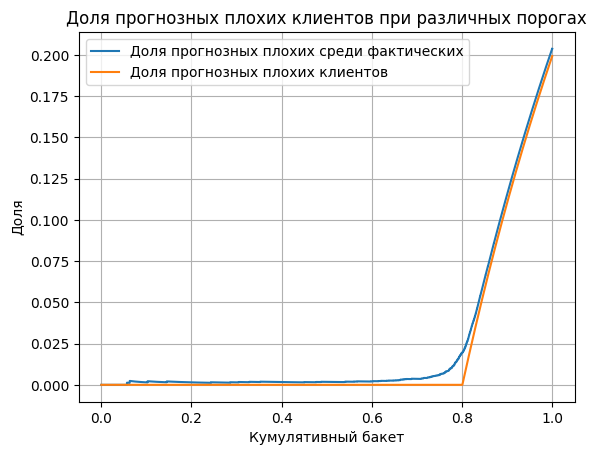

In [15]:
# Построим график
plot_cumulative_buckets(y_true, y_pred_proba)

По графику можно сказать следующее:
- Доля прогнозных "плохих" клиентов среди фактических:
    - На графике видно, что доля прогнозных "плохих" клиентов среди фактических (синяя линия) начинает резко расти после точки 0.8 на оси x (кумулятивный бакет). Это указывает на то, что после этой точки модель начинает классифицировать большинство клиентов как "плохих", но среди них фактически много "плохих" клиентов.
    - До этой точки (0.8) доля прогнозных "плохих" клиентов среди фактических клиентов остается практически нулевой. Это значит, что модель осторожно классифицирует клиентов как "плохих" и пропускает большую часть фактических "плохих" клиентов.

- Доля прогнозных "плохих" клиентов:
    - Оранжевая линия показывает долю прогнозных "плохих" клиентов. Эта линия также резко возрастает после точки 0.8, что говорит о том, что модель начинает резко предсказывать "плохих" клиентов.
    - Оранжевая линия проходит близко к синей линии, что указывает на хорошую точность модели: большинство прогнозируемых "плохих" клиентов действительно являются "плохими".

- Порог и кумулятивный бакет:
    - Значительное увеличение обеих метрик после точки 0.8 указывает на то, что модель более уверенно предсказывает "плохих" клиентов при более низких порогах, соответствующих высоким кумулятивным бакетам.
    - Это означает, что для получения наибольшей точности и полноты, порог должен быть настроен таким образом, чтобы включать более высокие кумулятивные бакеты (после 0.8).

### <a id="42">LightGBM</a>

In [194]:
# Получение весов классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [172]:
def objective_lgbm_class(trial):
    """Определение целевой функции для LightGBM Classification"""
    
    # Задаем сетку параметров
    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "depth": trial.suggest_int("depth", 4, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "force_col_wise": True,
        "verbose": -1,
        "class_weight": class_weights,
    }

    # Обучение модели
    optuna_model = LGBMClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_lgbm_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_lgbm_class.optimize(objective_lgbm_class, n_trials=100)

[I 2024-05-22 16:16:14,134] A new study created in memory with name: no-name-c34378f1-fbfa-4cd5-a7a2-af7940d97797
[I 2024-05-22 16:16:16,414] Trial 0 finished with value: 0.8046012746774444 and parameters: {'depth': 7, 'lambda_l1': 2.9860592461898377e-06, 'lambda_l2': 0.004153246229400488, 'num_leaves': 29, 'feature_fraction': 0.8744642401145606, 'bagging_fraction': 0.8007583337445545, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 0 with value: 0.8046012746774444.
[I 2024-05-22 16:16:20,918] Trial 1 finished with value: 0.8785915960803854 and parameters: {'depth': 10, 'lambda_l1': 1.199130607538965e-08, 'lambda_l2': 0.6814413693264321, 'num_leaves': 164, 'feature_fraction': 0.427849323767382, 'bagging_fraction': 0.976415508349007, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 1 with value: 0.8785915960803854.
[I 2024-05-22 16:16:23,984] Trial 2 finished with value: 0.8641114982578397 and parameters: {'depth': 4, 'lambda_l1': 0.00017103150608433637, 'lambda_l2':

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\682897915.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm_class)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

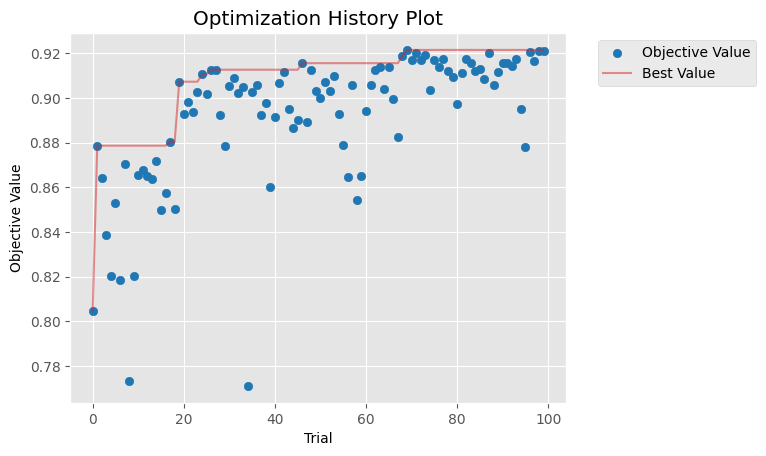

In [173]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_lgbm_class)

In [186]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_class.trials)))
print('Лучший трайл:')
trial = study_lgbm_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший F1-score: 0.9214696151837019
  Параметры: 
    depth: 7
    lambda_l1: 9.361964265136397e-08
    lambda_l2: 2.5027137388996596e-07
    num_leaves: 228
    feature_fraction: 0.6582724796939727
    bagging_fraction: 0.9759308186389867
    bagging_freq: 4
    min_child_samples: 5


In [187]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
lgbm_class = LGBMClassifier(verbose=-1, class_weight=class_weights, **params)
lgbm_class.fit(X_train, y_train)

# Конец временного промежутка
lgbm_class_time = time.time() - start_time

# Предсказание
y_pred_lgbm_class = lgbm_class.predict(X_test)

# Считаем основные метрики
f1_lgbm = f1_score(y_test, y_pred_lgbm_class)
acc_lgbm = accuracy_score(y_test, y_pred_lgbm_class)
prec_lgbm = precision_score(y_test, y_pred_lgbm_class)
rec_lgbm = recall_score(y_test, y_pred_lgbm_class)

# Выводим основные метрики
print(f"F1-score LightGBM: {f1_lgbm:.3f}")
print(f"Time LightGBM: {lgbm_class_time:.3f} сек")
print('Classification report LightGBM:')
print(classification_report(y_test, y_pred_lgbm_class))

F1-score LightGBM: 0.921
Time LightGBM: 5.732 сек
Classification report LightGBM:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10648
           1       0.88      0.97      0.92      2724

    accuracy                           0.97     13372
   macro avg       0.93      0.97      0.95     13372
weighted avg       0.97      0.97      0.97     13372



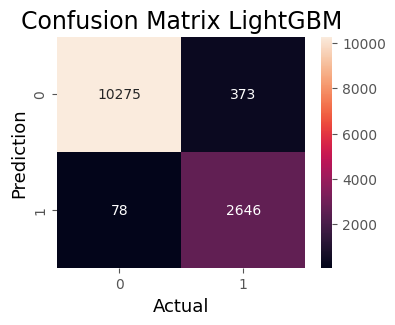

In [176]:
# Посмотрим на матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_lgbm = confusion_matrix(y_test, y_pred_lgbm_class)
sns.heatmap(con_mat_lgbm,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix LightGBM', fontsize=17)
plt.show()

Согласно метрикам качества данная модель показала хороший результат. Согласно матрице, ошибок первого рода меньше, чем ошибок второго рода.

$P_1<P_2$, где 

$P_1$ - отправлено письмо, которое не будет прочитано;

$P_2$ - письмо отправлено человеку, который бы его прочитал.

In [177]:
# Сохраним модель
with open(r'models/lgb_class_model.pkl', 'wb') as file:
    pickle.dump(lgbm_class, file)

In [17]:
# Загрузка модели из файла
with open(r'models/lgb_class_model.pkl', 'rb') as file:
    lgbm_class = pickle.load(file)

m:\venvs\pec_venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


m:\venvs\pec_venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


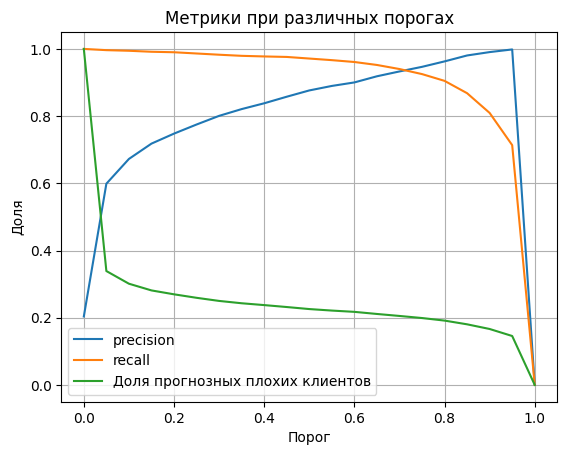

In [18]:
# Используйте ваши предсказания и истинные значения
y_true = y_test
y_pred_proba = lgbm_class.predict_proba(X_test)[:, 1]

# Построим график
plot_metrics_at_thresholds(y_true, y_pred_proba)

Выводы по этому графику:

- Precision (Точность):
    - Precision на высоких значениях порога (ближе к 1) почти достигает 1, что указывает на то, что при высоком пороге все предсказанные "плохие" клиенты действительно являются таковыми.
    - При уменьшении порога precision постепенно падает, но остается на высоком уровне (до 0,6) до порога около 0.1, после чего начинает стремительно снижаться. Это означает, что при низких порогах модель начинает допускать больше ложных срабатываний, т.е. классифицирует больше клиентов как "плохих", хотя они таковыми не являются.

- Recall (Полнота):
    - Recall остается высокой при низких значениях порога и постепенно снижается по мере увеличения порога. После 0,9 идет резкое снижение доли.
    - Это указывает на то, что при низких порогах модель успешно классифицирует большинство "плохих" клиентов, но по мере увеличения порога, количество обнаруживаемых "плохих" клиентов снижается.

- Доля прогнозных плохих клиентов:
    - Доля прогнозных "плохих" клиентов стремительно падает с уменьшением порога, особенно на промежутке 0.0-0.1. Это указывает на то, что при низких порогах модель классифицирует значительное число клиентов как "плохих", хотя это далеко не всегда так.
    - С увеличением порога доля стабилизируется и медленно снижается, что может указывать на устойчивость модели в определении "плохих" клиентов при низких порогах до 0,9.

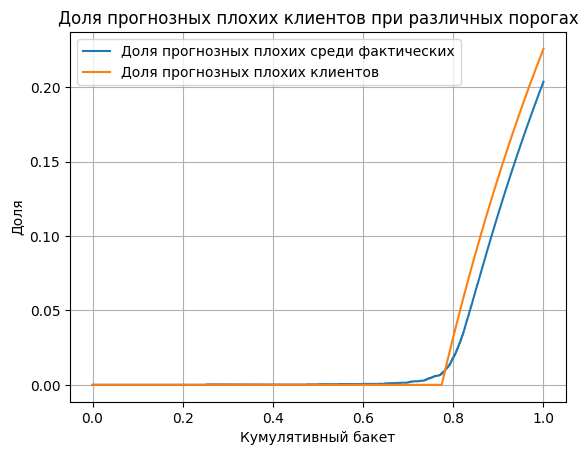

In [19]:
# Построим график
plot_cumulative_buckets(y_true, y_pred_proba)

По данному графику можно сказать следующее:
- Доля прогнозных плохих среди фактических клиентов:
    - В начальной части графика, вплоть до отметки около 0.75 по оси X, доля прогнозных плохих клиентов среди фактических очень низкая.
    - После отметки 0.75 происходит резкий рост, который достигает пика около 0.22 на отметке 1.0 по оси X.

- Доля прогнозных плохих клиентов:
    - Доля прогнозных плохих клиентов также начинает расти после отметки 0.75 и достигает пика на отметке 1.0 по оси X.
    - В начальной части графика доля прогнозных плохих клиентов почти совпадает с фактическими, что указывает на достаточно точное предсказание модели при низких порогах.

### <a id="43">XGBoost</a>

In [200]:
# Получение весов классов
weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [178]:
def objective_xgb_class(trial):
    """Определение целевой функции для XGBoost Classification"""

    # Подбираемые параметры
    params = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучение модели
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train, sample_weight=weights)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка полученного предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_xgb_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_xgb_class.optimize(objective_xgb_class, n_trials=50)

[I 2024-05-22 16:25:40,196] A new study created in memory with name: no-name-fc9e326e-35cf-4ec8-ba21-2b256e86ce65
[I 2024-05-22 16:25:50,310] Trial 0 finished with value: 0.7708111937654977 and parameters: {'learning_rate': 0.09318908775405846, 'n_estimators': 135, 'max_depth': 3, 'subsample': 0.6295510297331581, 'colsample_bytree': 0.5357317287001468}. Best is trial 0 with value: 0.7708111937654977.
[I 2024-05-22 16:28:17,472] Trial 1 finished with value: 0.9066859938394637 and parameters: {'learning_rate': 0.013487723917346123, 'n_estimators': 695, 'max_depth': 9, 'subsample': 0.8072020277566654, 'colsample_bytree': 0.6297492931717567}. Best is trial 1 with value: 0.9066859938394637.
[I 2024-05-22 16:28:57,327] Trial 2 finished with value: 0.8353221957040573 and parameters: {'learning_rate': 0.14123777798300383, 'n_estimators': 391, 'max_depth': 3, 'subsample': 0.9548597289534047, 'colsample_bytree': 0.987812286639495}. Best is trial 1 with value: 0.9066859938394637.
[I 2024-05-22 16

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\400001077.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_xgb_class)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

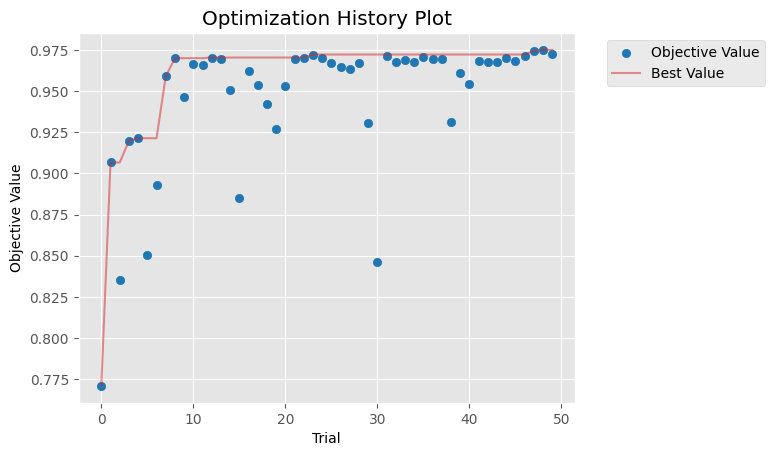

In [179]:
# Посмотрим как проходл процесс подбора параметров на графике
plot_optimization_history(study_xgb_class)

In [188]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_xgb_class.trials)))
print('Лучший трайл:')
trial = study_xgb_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 50
Лучший трайл:
  Лучший F1-score: 0.9751426993187259
  Параметры: 
    learning_rate: 0.1623223288327007
    n_estimators: 630
    max_depth: 9
    subsample: 0.999174873282843
    colsample_bytree: 0.6895631613730175


In [202]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель с полученными параметрами
params = trial.params
xgb_class = XGBClassifier(**params)
xgb_class.fit(X_train, y_train, sample_weight=weights)

# Конец временного промежутка
xgb_class_time = time.time() - start_time

# Предсказание
y_pred_xgb_class = xgb_class.predict(X_test)

# Вычислим основные метрики
f1_xgb = f1_score(y_test, y_pred_xgb_class)
acc_xgb = accuracy_score(y_test, y_pred_xgb_class)
prec_xgb = precision_score(y_test, y_pred_xgb_class)
rec_xgb = recall_score(y_test, y_pred_xgb_class)

# Посмотрим на основные метрики качества
print(f"F1-score XGBoost: {f1_xgb:.3f}")
print(f"Time XGBoost: {xgb_class_time:.3f}")
print('Classification report XGBoost:')
print(classification_report(y_test, y_pred_xgb_class))

F1-score XGBoost: 0.971
Time XGBoost: 129.150
Classification report XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10648
           1       0.96      0.99      0.97      2724

    accuracy                           0.99     13372
   macro avg       0.98      0.99      0.98     13372
weighted avg       0.99      0.99      0.99     13372



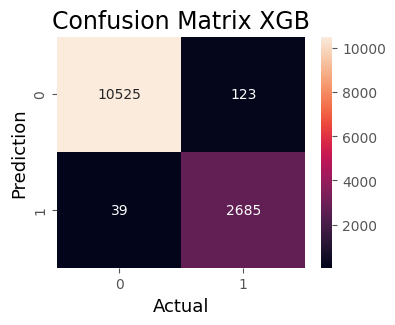

In [203]:
# Потроим матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_xgb = confusion_matrix(y_test, y_pred_xgb_class)
sns.heatmap(con_mat_xgb,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix XGB', fontsize=17)
plt.show()

Согласно метрикам качества данная модель показала хороший результат, самый лучший из представленных. Согласно матрице, ошибок первого рода меньше, чем ошибок второго рода.

$P_1<P_2$, где 

$P_1$ - отправлено письмо, которое не будет прочитано;

$P_2$ - письмо отправлено человеку, который бы его прочитал.

In [204]:
# Сохраним полученную модель
with open(r'models/xgb_class_model.pkl', 'wb') as file:
    pickle.dump(xgb_class, file)

In [ ]:
# Загрузка модели из файла
with open(r'models/xgb_class_model.pkl', 'rb') as file:
    xgb_class = pickle.load(file)

m:\venvs\pec_venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


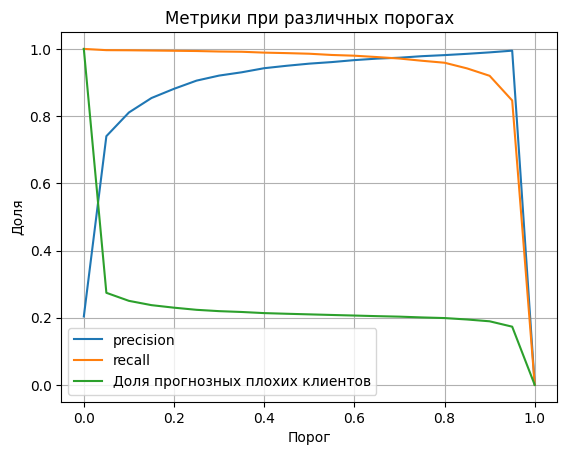

In [21]:
# Используйте ваши предсказания и истинные значения
y_true = y_test
y_pred_proba = xgb_class.predict_proba(X_test)[:, 1]

# Построим график
plot_metrics_at_thresholds(y_true, y_pred_proba)

Выводы по этому графику:

- Precision (точность):
    - Точность модели начинается с низкой отметки доли в 0.2 и резко увеличивается до 0.9 при пороге 0.2.
    - После этого точность стабильно растет и достигает почти 1.0 на высоких порогах (0.8-1.0).

- Recall (полнота):
    - Полнота модели начинается с максимального значения (1.0) при низких порогах и резко снижается до значения около 0 начиная с порога 0.9.
    - При порогах в диапазоне от 0.0 до 0.4 полнота остается стабильной и высокой, но начинает снижаться после порога 0.4.

- Доля прогнозных "плохих" клиентов:
    - Доля прогнозных "плохих" клиентов стремительно падает с уменьшением порога, особенно на промежутке 0.0-0.05 также как и на предыдущих графиках. Это указывает на то, что при низких порогах модель классифицирует значительное число клиентов как "плохих", хотя это далеко не всегда так.
    - С увеличением порога доля стабилизируется и медленно снижается, что может указывать на устойчивость модели в определении "плохих" клиентов при низких порогах до 0,95. 

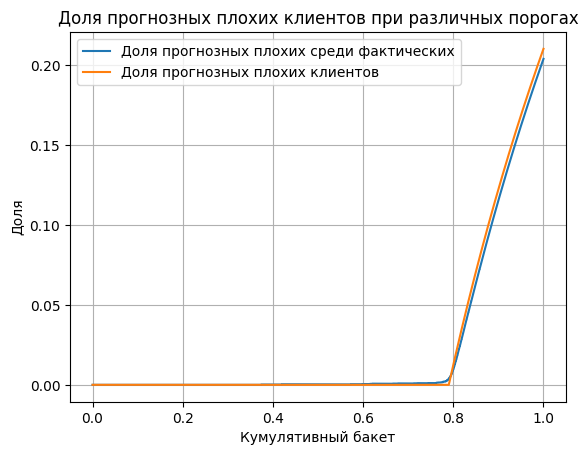

In [22]:
# Построим график
plot_cumulative_buckets(y_true, y_pred_proba)

По данному графику можно сказать следующее:
- Сравнение доли прогнозных плохих клиентов:
    - Оранжевая линия представляет долю прогнозных плохих клиентов, а синяя линия - долю фактических плохих клиентов.
    - Обе линии начинают резко расти после отметки кумулятивного бакета около 0.8 и достигают максимального значения к 1.0.

- Точность прогноза:
    - Обе линии практически совпадают на всем протяжении графика, что свидетельствует о высокой точности модели XGBoost в прогнозировании плохих клиентов.
    - Совпадение линий указывает на то, что модель хорошо идентифицирует плохих клиентов на различных уровнях порогов.

- Поведение на низких и средних бакетах:
    - На низких и средних бакетах (до 0.8) доля прогнозных плохих клиентов остается близкой к нулю, что говорит о том, что модель минимально ошибается на этих уровнях.
    - Это поведение указывает на то, что модель способна эффективно отсеивать хороших клиентов от плохих при низких и средних порогах.

### <a id="44">Сравнение 3-х моделей классификации</a>

In [206]:
# Соберем основные метрики по моделям в одну таблицу
classification_df = pd.DataFrame(
    data = [
        [ f'{f1_catb:.3f}', f'{f1_lgbm:.3f}', f'{f1_xgb:.3f}'],
        [f'{acc_catb:.3f}', f'{acc_lgbm:.3f}', f'{acc_xgb:.3f}'],
        [f'{prec_catb:.3f}', f'{prec_lgbm:.3f}', f'{prec_xgb:.3f}'],
        [f'{rec_catb:.3f}', f'{rec_lgbm:.3f}', f'{rec_xgb:.3f}'],
        [f'{catb_class_time:.2f} сек', f'{lgbm_class_time:.2f} сек', f'{xgb_class_time:.2f} сек']
    ],
    columns= [ 'CatBoost', 'LightGBM','XGBoost'],
    index = ['F1-score', 'Accuracy', 'Precision', 'Recall', 'Time']
)
display(classification_df)

,CatBoost,LightGBM,XGBoost
F1-score,0.933,0.921,0.971
Accuracy,0.973,0.966,0.988
Precision,0.943,0.876,0.956
Recall,0.923,0.971,0.986
Time,61.08 сек,5.73 сек,129.15 сек


> Все построенные модели классификации показали качественные результаты, лучше всех справилась модель XGBoost, но аналогично с регрессией на нее уходит больше всего времени для обучения.

> По итогам данной работы было обучено 6 моделей, 3 на классификацию и 3 на регрессию, полученные метрики качества позволяют внедрять их в реальные задачи R2-score > 80% и F1-score > 0.8. 

> Вариант регрессии является более гибким, отдел маркетинга может самостоятельно выбрать границу вероятности, на которую стоит опираться при рассылке рекламных предложений. Вариант же классификации также имеет в себе некую гибкость, можно изменить порог отнесения тех или иных данных к 0-му ли 1-му классу, что представлено в ноутбуке select_features.ipynb

### <a id="5">Получим предсказания для данных на 2024 год</a>

In [44]:
# Загрузим данные из файла
df_pred = pd.read_csv('../feature_selection/data/raw_selected_data.csv')

# Удалим ненужные столбцы
df_pred = df_pred.drop(['percent_nClick', 'BinNclick'], axis=1)

# Стандартизируем данные
sc = StandardScaler()
sc.fit(df_pred)
X_2024=sc.transform(df_pred)

In [45]:
# Загрузим модели
with open("models/xgb_reg_model.pkl", "rb") as f:
    xgb_reg = pickle.load(f)
with open("models/xgb_class_model.pkl", "rb") as f:
    xgb_class = pickle.load(f)

# Получим предсказания 
pred_xgb_reg = xgb_reg.predict(X_2024)
pred_xgb_class = xgb_class.predict(X_2024)

In [46]:
# Посмотрим на распределение предсказаний классификации
unique, counts = np.unique(pred_xgb_class, return_counts=True)
dict(zip(unique, counts))

{0: 51551, 1: 15308}

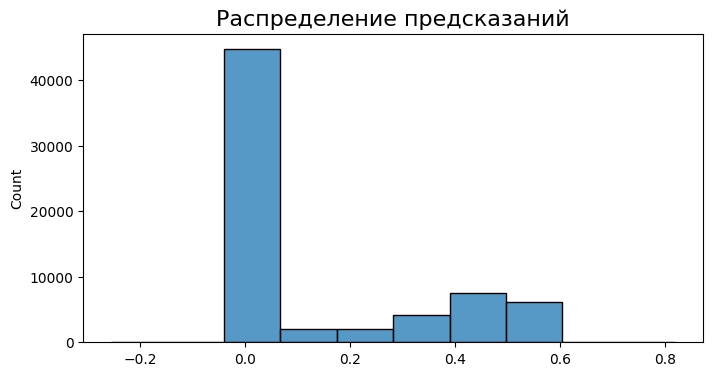

In [47]:
# Посмотрим на распределение предсказаний регрессии
fig = plt.figure(figsize=(8, 4))
histplot = sns.histplot(
    data=pred_xgb_reg,
    bins=10
)
histplot.set_title('Распределение предсказаний', fontsize=16)

In [49]:
# Сохраним получившиеся предсказания в csv
id = np.arange(pred_xgb_reg.shape[0])
result_reg = pd.DataFrame({
    'Id': id,
    'Pred': pred_xgb_reg
})
result_reg.to_csv('../data/predict/predict_xgb_regression.csv', index=False)

result_class = pd.DataFrame({
    'Id': id,
    'Pred': pred_xgb_class
})
result_class.to_csv('../data/predict/predict_xgb_classification.csv', index=False)